In [1]:
import numpy as np
import cupy as cp
from tqdm import tqdm
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files('movie_review')
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

in_features= 1800

vectorizer = CountVectorizer(max_features=in_features, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.3, shuffle=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jtige\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jtige\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_texts, test_texts = cp.asarray(train_texts), cp.asarray(test_texts)
train_labels, test_labels = cp.asarray(train_labels), cp.asarray(test_labels)
train_labels, test_labels = cp.expand_dims(train_labels, axis=1), cp.expand_dims(test_labels, axis=1)

In [3]:
# Define module
def sigmoid(x):
    return 1 / (1 + cp.exp(-x))


class HiddenLayer:
    def __init__(self, in_shape, out_shape):
        std = cp.sqrt(2 / (in_shape + out_shape))
        self.weight = cp.random.normal(0, std, (out_shape, in_shape))
        self.bias = cp.random.normal(0, 1e-6, (out_shape, 1))
    
    def __call__(self, x):
        self.input = x
        return sigmoid(x @ self.weight.T + self.bias.T)
    
    def backprop(self, error, lr, weight_decay=0):
        batch_size = self.input.shape[0]
        
        self.weight -= lr * (error.T @ self.input + weight_decay * self.weight) / batch_size
        self.bias -= lr * (error.T.sum(axis=1, keepdims=True) + weight_decay * self.bias) / batch_size
        
        return error @ self.weight * (self.input * (1 - self.input))
        
    
class Sequential:
    def __init__(self, module_list):
        self.module_list = module_list
    
    def __call__(self, x):
        for layer in self.module_list:
            x = layer(x)
        return x    
    
    def backprop(self, pred, label, lr, weight_decay):
        error = pred - label
        for layer in reversed(self.module_list):
            error = layer.backprop(error, lr, weight_decay)
        
class BinaryCrossEntropy:
    labels = 0
    preds = 0
    def __call__(self, preds, labels):
        self.labels = labels
        self.preds = preds
        
        return -(labels * cp.log(preds) + (1 - labels) * cp.log(1 - preds)).mean()
    
class LearningRateScheduler:
    def __init__(self, init_lr, final_step, warm_up_step = 0):
        self.init_lr = init_lr
        self.final_step = final_step
        self.warm_up_step = warm_up_step
        self.lr = 0
        self._step = 0
    
    def step(self):
        self._step += 1
        # Learning rate Warm-up
        if (self._step < self.warm_up_step):
            self.lr = (self.init_lr / self.warm_up_step) * self._step
        # Cos scheduler
        else:
            self.lr = (cp.cos(cp.pi * ((self._step - self.warm_up_step) / (self.final_step - self.warm_up_step))) + 1) / 2 * self.init_lr
        
    def get_lr(self):
        return self.lr

In [4]:
# define computation
def compute_acc(preds, labels):
    preds = preds >= 0.5
    return (preds == labels).sum() / preds.shape[0]

In [5]:
print(train_texts.shape)
print(test_texts.shape)
print(train_labels.shape)
print(test_labels.shape)

(1400, 1800)
(600, 1800)
(1400, 1)
(600, 1)


In [6]:
# defclare hyterparamter
epoch = 170000
warm_up_epoch = epoch // 10
initial_lr = 1e-2
weight_decay = 1e-3

num_feature = [400, 100]

block = []
out_features = 1

for nf in num_feature:
    block += [HiddenLayer(in_features, nf)]
    in_features = nf

block += [HiddenLayer(in_features, out_features)]

model = Sequential(block)

criterion = BinaryCrossEntropy()
lr = LearningRateScheduler(initial_lr, epoch, warm_up_epoch)

In [7]:
train_accuracyes = []
test_accuracyes = []
train_losses = []
test_losses = []
lrs = []

for step in tqdm(range(epoch)):
    # predict test label
    test_preds = model(test_texts)
    test_loss = criterion(test_preds, test_labels)
    test_acc = compute_acc(test_preds, test_labels)
    
    # predict train label
    train_preds = model(train_texts)
    train_loss = criterion(train_preds, train_labels)
    train_acc = compute_acc(train_preds, train_labels)
    
    # backporpagation
    model.backprop(train_preds, train_labels, lr.lr, weight_decay)
    
    # save results
    train_accuracyes += [float(train_acc) * 100]
    test_accuracyes += [float(test_acc) * 100]
    
    train_losses += [train_loss]
    test_losses += [test_loss]
    lrs += [lr.lr]
    
    lr.step()

train_preds = train_preds >= 0.5
test_preds = test_preds >= 0.5

100%|████████████████████████████████████████████████████████████████████████| 170000/170000 [1:40:50<00:00, 28.10it/s]


In [8]:
# Split correct answer and worng answer

is_correct = cp.argmax(test_preds, axis=1) == cp.argmax(test_labels, axis=1)

correct_images = test_texts[is_correct]
correct_labels = test_preds[is_correct]

worng_images = test_texts[cp.logical_not(is_correct)]
worng_labels = test_preds[cp.logical_not(is_correct)]

correct_images.shape, worng_images.shape

((600, 1800), (0, 1800))

## 1. Plot the loss curve

c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


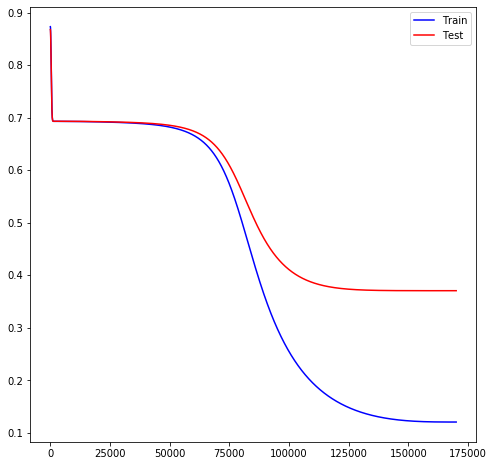

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(train_losses, label='Train', c='b')
plt.plot(test_losses, label='Test', c='r')
plt.legend()
plt.show()

## 2. Plot the accuracy curve

c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


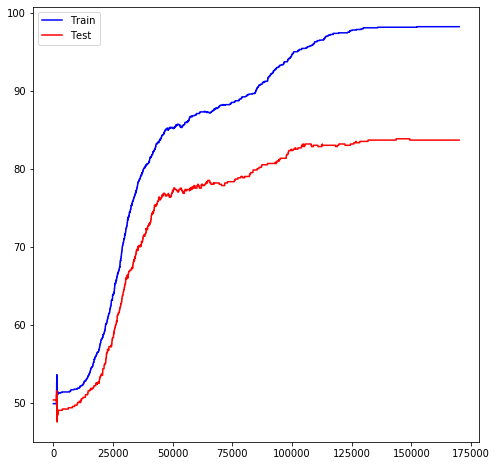

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(train_accuracyes, label='Train', c='b')
plt.plot(test_accuracyes, label='Test', c='r')
plt.legend()
plt.show()


## 3. Plot the quantitative results

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(cp.asnumpy(train_labels), cp.asnumpy(train_preds)))
print(classification_report(cp.asnumpy(train_labels), cp.asnumpy(train_labels)))
print(accuracy_score(cp.asnumpy(train_labels), cp.asnumpy(train_preds)))
print("\n")
print(confusion_matrix(cp.asnumpy(test_labels), cp.asnumpy(test_preds)))
print(classification_report(cp.asnumpy(test_labels), cp.asnumpy(test_preds)))
print(accuracy_score(cp.asnumpy(test_labels), cp.asnumpy(test_preds)))

[[684  14]
 [ 11 691]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

0.9821428571428571


[[255  47]
 [ 51 247]]
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       302
           1       0.84      0.83      0.83       298

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

0.8366666666666667


## 4. Testing accuracy

In [12]:
print(f'Final Test Accuracy: {test_accuracyes[-1]}%')

Final Test Accuracy: 83.66666666666667%
